In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

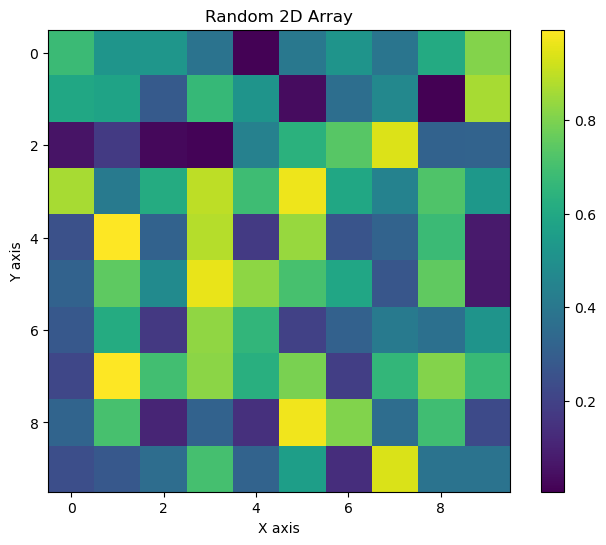

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight

        self.out_channel = 1

        # 파라미터 
        self.conv_depthwise = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                        kernel_size=self.receptive_size, 
                                        stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.conv_depthwise.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv_depthwise.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
            recurrent_current = self.conv_depthwise(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class NO_RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(NO_RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        # with torch.no_grad():
        #     x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        with torch.no_grad():
            x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [8]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        
        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)

        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        exclude_class = 10
        train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
        test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
    
        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}


    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [9]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Accuracy: {val_accuracy:.2f}%")


In [10]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if no_reservoir == True:
        net = NO_RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    else:
        net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [11]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False)

In [12]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir)



which_data_hyper = 'DVS_GESTURE' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': which_data_hyper,
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"min": 0.00001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"min": 0.25, "max": 1.0},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [50]},
        "IMAGE_SIZE": {"values": [16,32,48,128]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent('0j0aowy8', function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: oqo7bwqd
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/oqo7bwqd


wandb: Agent Starting Run: fltzcvan with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.923388226765121
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.0321303117407223
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.950912228526025
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.63%
Test loss: 66.348, Accuracy: 43.56%
Epoch 2
Train Accuracy: 65.12%
Test loss: 27.937, Accuracy: 67.80%
Epoch 3
Train Accuracy: 75.88%
Test loss: 110.606, Accuracy: 50.38%
Epoch 4
Train Accuracy: 75.14%
Test loss: 49.178, Accuracy: 58.71%
Epoch 5
Train Accuracy: 76.99%
Test loss: 84.985, Accuracy: 61.74%
Epoch 6
Train Accuracy: 78.94%
Test loss: 43.889, Accuracy: 67.05%
Epoch 7
Train Accuracy: 85.90%
Test loss: 53.703, Accuracy: 56.44%
Epoch 8
Train Accuracy: 91.56%
Test loss: 38.490, Accuracy: 66.29%
Epoch 9
Train Accuracy: 96.20%
Test loss: 22.798, Accuracy: 70.83%
Epoch 10
Train Accuracy: 96.75%
Test loss: 28.535, Accuracy

iter_accuracy,▂▄▄▁▇▅▆▇██▅█▇██▇████████████████████████
tr_accuracy,▁▄▅▅▆▆▇█▇▇▇▇▇█▇█████████████████████████
val_accuracy,▁▇▃▅▇▄▇█▇▅█▇▇▆▆██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22f99laq with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.2740315168442979
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.05959519657116801
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.29145092060441
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.43%
Test loss: 1.650, Accuracy: 41.67%
Epoch 2
Train Accuracy: 52.69%
Test loss: 1.355, Accuracy: 48.11%
Epoch 3
Train Accuracy: 59.83%
Test loss: 1.496, Accuracy: 50.38%
Epoch 4
Train Accuracy: 67.16%
Test loss: 1.180, Accuracy: 54.92%
Epoch 5
Train Accuracy: 73.56%
Test loss: 1.112, Accuracy: 59.09%
Epoch 6
Train Accuracy: 73.47%
Test loss: 1.139, Accuracy: 58.33%
Epoch 7
Train Accuracy: 77.37%
Test loss: 1.624, Accuracy: 58.33%
Epoch 8
Train Accuracy: 76.90%
Test loss: 1.378, Accuracy: 59.09%
Epoch 9
Train Accuracy: 79.87%
Test loss: 1.455, Accuracy: 57.95%
Epoch 10
Train Accuracy: 79.04%
Test loss: 1.223, Accuracy: 58.33%
Epoc

iter_accuracy,▁▂▁▃▄▅▅▅▇▇▇▇▆▇▇▇██▇████▇▇█▇█████████████
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████▇▇▇██████████████
val_accuracy,▁▃▄▅▆▆▆▆▇█▆▇▆▇▆▇▆▇▇██▇▇▆▇▇▇▆▆▇▇▇▇▆▇█▇▇▇▇
iter_accuracy,100.0
tr_accuracy,99.25788
val_accuracy,60.60606


wandb: Agent Starting Run: ac6ls9a3 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5342228737477184
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.026121584856232703
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.1336473162092133
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.30%
Test loss: 1.669, Accuracy: 34.85%
Epoch 2
Train Accuracy: 49.81%
Test loss: 1.345, Accuracy: 54.92%
Epoch 3
Train Accuracy: 56.12%
Test loss: 1.829, Accuracy: 54.17%
Epoch 4
Train Accuracy: 60.85%
Test loss: 1.097, Accuracy: 57.95%
Epoch 5
Train Accuracy: 62.99%
Test loss: 1.430, Accuracy: 57.95%
Epoch 6
Train Accuracy: 69.02%
Test loss: 2.062, Accuracy: 54.17%
Epoch 7
Train Accuracy: 71.43%
Test loss: 1.614, Accuracy: 57.20%
Epoch 8
Train Accuracy: 76.07%
Test loss: 1.391, Accuracy: 60.61%
Epoch 9
Train Accuracy: 78.39%
Test loss: 1.472, Accuracy: 60.23%
Epoch 10
Train Accuracy: 76.81%
Test loss: 1.477, Accuracy: 61.74%
Epo

iter_accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇██▇████████████████████
tr_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇███████████████████
val_accuracy,▁▅▅▆▅▆▆▆█▇▆▆▇▆▇██▇▇▇▇▆▇▇▇▇▇█▇█▇██▇██▇▇▇▇
iter_accuracy,100.0
tr_accuracy,99.72171
val_accuracy,64.77273


wandb: Agent Starting Run: pfpnvg31 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9326104311562914
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.026441586959243948
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.532159569314796
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.37%
Test loss: 62.659, Accuracy: 48.48%
Epoch 2
Train Accuracy: 59.93%
Test loss: 72.003, Accuracy: 59.09%
Epoch 3
Train Accuracy: 70.78%
Test loss: 33.590, Accuracy: 56.44%
Epoch 4
Train Accuracy: 74.86%
Test loss: 46.471, Accuracy: 53.79%
Epoch 5
Train Accuracy: 79.96%
Test loss: 19.141, Accuracy: 64.77%
Epoch 6
Train Accuracy: 89.33%
Test loss: 18.450, Accuracy: 62.88%
Epoch 7
Train Accuracy: 90.91%
Test loss: 19.668, Accuracy: 62.50%
Epoch 8
Train Accuracy: 91.47%
Test loss: 16.078, Accuracy: 64.02%
Epoch 9
Train Accuracy: 89.15%
Test loss: 25.128, Accuracy: 67.42%
Epoch 10
Train Accuracy: 91.37%
Test loss: 20.658, Accura

iter_accuracy,▁▅▇▆▆▇▄██▆███▇█▇████████████████████████
tr_accuracy,▁▃▅▅▇▇▇▇▇▇██████▇███████████████████████
val_accuracy,▁▄▃▃▅▅▆▇▆▆▅▆▇▇▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.07576


wandb: Agent Starting Run: reea4hqy with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5652978632799668
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.0990144465846309
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.691782674653536
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.10%
Test loss: 1.827, Accuracy: 42.05%
Epoch 2
Train Accuracy: 56.22%
Test loss: 1.299, Accuracy: 54.92%
Epoch 3
Train Accuracy: 62.34%
Test loss: 1.694, Accuracy: 56.06%
Epoch 4
Train Accuracy: 68.46%
Test loss: 1.482, Accuracy: 56.06%
Epoch 5
Train Accuracy: 72.45%
Test loss: 1.266, Accuracy: 60.98%
Epoch 6
Train Accuracy: 79.59%
Test loss: 1.635, Accuracy: 56.44%
Epoch 7
Train Accuracy: 76.35%
Test loss: 1.264, Accuracy: 62.12%
Epoch 8
Train Accuracy: 80.52%
Test loss: 1.231, Accuracy: 62.88%
Epoch 9
Train Accuracy: 78.57%
Test loss: 1.178, Accuracy: 63.64%
Epoch 10
Train Accuracy: 81.82%
Test loss: 1.432, Accuracy: 59.09%
Epoc

iter_accuracy,▁▃▅▆▆▇▇▆▇▆▇▇▇▇██▇▇██▇▇▇████▇██████████▇█
tr_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_accuracy,▁▅▅▅▅▆▇▇▇██▇▇▇▆██▆▇▆▆▇▇▇▇█▇▇▇▇▆▇▇▆▇▅▆▆▆▇
iter_accuracy,98.14815
tr_accuracy,98.23748
val_accuracy,63.63636


wandb: Agent Starting Run: z7l1yeux with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9905740142872672
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.052716881645520595
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5034640403356565
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.14%
Test loss: 10.626, Accuracy: 23.11%
Epoch 2
Train Accuracy: 14.38%
Test loss: 24.702, Accuracy: 23.48%
Epoch 3
Train Accuracy: 24.77%
Test loss: 25.146, Accuracy: 37.50%
Epoch 4
Train Accuracy: 36.55%
Test loss: 24.810, Accuracy: 28.79%
Epoch 5
Train Accuracy: 33.86%
Test loss: 13.736, Accuracy: 35.23%
Epoch 6
Train Accuracy: 43.97%
Test loss: 15.250, Accuracy: 29.92%
Epoch 7
Train Accuracy: 43.32%
Test loss: 8.320, Accuracy: 38.26%
Epoch 8
Train Accuracy: 59.55%
Test loss: 7.942, Accuracy: 49.62%
Epoch 9
Train Accuracy: 63.73%
Test loss: 7.194, Accuracy: 55.30%
Epoch 10
Train Accuracy: 67.90%
Test loss: 2.689, Accuracy: 5

iter_accuracy,▂▁▂▄▄▄▅▆▅▆▆▇▇▇▇██▇██████████████████████
tr_accuracy,▁▁▂▃▃▃▅▅▅▆▆▇▇▇▇█████████████████████████
val_accuracy,▁▁▃▂▂▃▅▆▆▆▆▇▇▇▇▇▇▇███▇████▇▇▇███████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.18182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m713uap5 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5003353973710729
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.06641585829057639
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.2006716253104224
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.25%
Test loss: 2.097, Accuracy: 17.80%
Epoch 2
Train Accuracy: 37.29%
Test loss: 1.781, Accuracy: 37.88%
Epoch 3
Train Accuracy: 47.31%
Test loss: 2.039, Accuracy: 46.21%
Epoch 4
Train Accuracy: 54.55%
Test loss: 1.160, Accuracy: 46.97%
Epoch 5
Train Accuracy: 52.78%
Test loss: 1.758, Accuracy: 53.79%
Epoch 6
Train Accuracy: 60.85%
Test loss: 1.827, Accuracy: 51.89%
Epoch 7
Train Accuracy: 59.00%
Test loss: 1.251, Accuracy: 57.95%
Epoch 8
Train Accuracy: 66.60%
Test loss: 2.033, Accuracy: 54.92%
Epoch 9
Train Accuracy: 66.51%
Test loss: 1.230, Accuracy: 58.33%
Epoch 10
Train Accuracy: 69.39%
Test loss: 1.516, Accuracy: 59.47%
Epoc

iter_accuracy,▁▄▅▅▅▄▆▆▆▆▆▆▇▇▆▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇██▇▇▇▇▇█▇
tr_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇██▇▇▇▇▇████████████▇██
val_accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▇▇▇▇█▇███▇▇█▇██▇█▇█▇██▇▇█▇█▇
iter_accuracy,90.74074
tr_accuracy,90.44527
val_accuracy,62.87879


wandb: Agent Starting Run: hge2cqd1 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6124048052580667
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.0881579525155855
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.673009385367648
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.53%
Test loss: 15.505, Accuracy: 38.64%
Epoch 2
Train Accuracy: 51.86%
Test loss: 5.119, Accuracy: 55.68%
Epoch 3
Train Accuracy: 67.72%
Test loss: 6.980, Accuracy: 49.62%
Epoch 4
Train Accuracy: 70.96%
Test loss: 3.889, Accuracy: 55.68%
Epoch 5
Train Accuracy: 75.51%
Test loss: 5.388, Accuracy: 57.95%
Epoch 6
Train Accuracy: 70.69%
Test loss: 5.279, Accuracy: 48.48%
Epoch 7
Train Accuracy: 76.35%
Test loss: 6.107, Accuracy: 59.09%
Epoch 8
Train Accuracy: 76.90%
Test loss: 4.888, Accuracy: 51.14%
Epoch 9
Train Accuracy: 81.08%
Test loss: 3.414, Accuracy: 58.33%
Epoch 10
Train Accuracy: 86.09%
Test loss: 4.883, Accuracy: 57.95%
Ep

iter_accuracy,▁▃▅▅▅▆▆▆█▇▇█▇███████████████████████████
tr_accuracy,▁▃▅▅▅▆▆▆▇▇█▇████████████████████████████
val_accuracy,▁▅▄▅▃▆▄▆▇▇▇█▆▇████████▇████▇████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.42424


wandb: Agent Starting Run: lmbetrop with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4797468408272183
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.053229334043457345
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.99452249387473
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 12.99%
Test loss: 67.185, Accuracy: 16.67%
Epoch 2
Train Accuracy: 34.69%
Test loss: 18.250, Accuracy: 44.70%
Epoch 3
Train Accuracy: 55.84%
Test loss: 6.515, Accuracy: 55.68%
Epoch 4
Train Accuracy: 68.09%
Test loss: 6.836, Accuracy: 56.82%
Epoch 5
Train Accuracy: 77.18%
Test loss: 7.476, Accuracy: 54.55%
Epoch 6
Train Accuracy: 79.41%
Test loss: 3.508, Accuracy: 63.26%
Epoch 7
Train Accuracy: 85.81%
Test loss: 3.259, Accuracy: 62.12%
Epoch 8
Train Accuracy: 94.25%
Test loss: 3.086, Accuracy: 65.53%
Epoch 9
Train Accuracy: 96.01%
Test loss: 3.084, Accuracy: 65.53%
Epoch 10
Train Accuracy: 96.75%
Test loss: 2.732, Accuracy: 68.56%
E

iter_accuracy,▁▁▄▅▅▇▇███▇█████████████████████████████
tr_accuracy,▁▃▄▅▆▇████▇▇████████████████████████████
val_accuracy,▁▅▆▆▇▇▇▇▇█▇▇██▇▇▇▇▇█████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.83333


wandb: Agent Starting Run: rt46jzis with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.33400629778000646
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.03514869601891086
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.835839687872928
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.04%
Test loss: 2.276, Accuracy: 43.94%
Epoch 2
Train Accuracy: 41.19%
Test loss: 1.713, Accuracy: 47.73%
Epoch 3
Train Accuracy: 51.86%
Test loss: 1.450, Accuracy: 56.82%
Epoch 4
Train Accuracy: 66.70%
Test loss: 2.098, Accuracy: 56.44%
Epoch 5
Train Accuracy: 76.25%
Test loss: 1.744, Accuracy: 59.09%
Epoch 6
Train Accuracy: 76.90%
Test loss: 1.465, Accuracy: 57.20%
Epoch 7
Train Accuracy: 80.24%
Test loss: 1.525, Accuracy: 64.39%
Epoch 8
Train Accuracy: 83.30%
Test loss: 1.321, Accuracy: 64.77%
Epoch 9
Train Accuracy: 87.20%
Test loss: 1.785, Accuracy: 59.85%
Epoch 10
Train Accuracy: 89.42%
Test loss: 1.594, Accuracy: 58.71%
Epo

iter_accuracy,▁▃▄▆▇▇▇▇▇███▇███████████████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇█▇▇▇███████████████████████████
val_accuracy,▁▂▄▄▅▆▇▅▇▇▇▇▅▇▇▇▇█▇▇▇▇▇▇▇▇██▇█▇▇█▇█▇▇▇▇█
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: mqvxcls6 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.2592763883886717
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.07727250322975296
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4348541952755631
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.37%
Test loss: 53.251, Accuracy: 24.24%
Epoch 2
Train Accuracy: 42.58%
Test loss: 18.930, Accuracy: 44.70%
Epoch 3
Train Accuracy: 57.98%
Test loss: 10.844, Accuracy: 52.27%
Epoch 4
Train Accuracy: 68.27%
Test loss: 7.845, Accuracy: 55.68%
Epoch 5
Train Accuracy: 75.70%
Test loss: 4.956, Accuracy: 60.98%
Epoch 6
Train Accuracy: 82.37%
Test loss: 11.451, Accuracy: 54.92%
Epoch 7
Train Accuracy: 81.26%
Test loss: 8.636, Accuracy: 60.23%
Epoch 8
Train Accuracy: 86.92%
Test loss: 8.442, Accuracy: 64.77%
Epoch 9
Train Accuracy: 86.55%
Test loss: 7.460, Accuracy: 62.12%
Epoch 10
Train Accuracy: 92.02%
Test loss: 8.775, Accuracy: 59.

iter_accuracy,▁▁▃▅▆▆▇▆██▇█████████████████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇█████████████████████████████
val_accuracy,▁▄▅▆▆▇▇▇▆▇▆▇█▇██▇███████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.56061


wandb: Agent Starting Run: g4p81e8c with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.3247399056932315
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.0887050710429105
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8896417696560175
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 12.89%
Test loss: 7.122, Accuracy: 15.53%
Epoch 2
Train Accuracy: 22.08%
Test loss: 8.686, Accuracy: 26.52%
Epoch 3
Train Accuracy: 29.68%
Test loss: 19.637, Accuracy: 27.65%
Epoch 4
Train Accuracy: 28.76%
Test loss: 4.072, Accuracy: 39.39%
Epoch 5
Train Accuracy: 46.01%
Test loss: 8.821, Accuracy: 42.42%
Epoch 6
Train Accuracy: 51.48%
Test loss: 9.015, Accuracy: 42.42%
Epoch 7
Train Accuracy: 57.42%
Test loss: 3.827, Accuracy: 42.42%
Epoch 8
Train Accuracy: 55.10%
Test loss: 8.371, Accuracy: 50.76%
Epoch 9
Train Accuracy: 61.13%
Test loss: 3.362, Accuracy: 57.20%
Epoch 10
Train Accuracy: 67.90%
Test loss: 4.980, Accuracy: 56.06%

iter_accuracy,▁▃▂▂▄▄▄▆▆▆▇▆▆▆▇██▇██████████████████████
tr_accuracy,▁▂▂▂▄▅▄▅▆▆▆▆▇▇▇▇█▇██████████████████████
val_accuracy,▁▂▃▄▄▄▅▆▅▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇██████████████▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,66.66667


wandb: Agent Starting Run: 6myu1vth with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.45560296278768353
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.08138669827615244
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4980389278826305
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.96%
Test loss: 14.499, Accuracy: 45.08%
Epoch 2
Train Accuracy: 34.42%
Test loss: 4.472, Accuracy: 32.95%
Epoch 3
Train Accuracy: 42.58%
Test loss: 5.095, Accuracy: 48.11%
Epoch 4
Train Accuracy: 57.79%
Test loss: 2.728, Accuracy: 55.68%
Epoch 5
Train Accuracy: 63.27%
Test loss: 3.005, Accuracy: 51.52%
Epoch 6
Train Accuracy: 67.16%
Test loss: 1.744, Accuracy: 52.27%
Epoch 7
Train Accuracy: 70.41%
Test loss: 2.351, Accuracy: 52.27%
Epoch 8
Train Accuracy: 78.01%
Test loss: 2.136, Accuracy: 62.88%
Epoch 9
Train Accuracy: 83.30%
Test loss: 2.172, Accuracy: 58.33%
Epoch 10
Train Accuracy: 82.93%
Test loss: 1.675, Accuracy: 63.26%
Ep

In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
